In [0]:
!pip install keras_efficientnets

# load package

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input, Dropout
from keras.models import Sequential, Model
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras_efficientnets import EfficientNetB3
from sklearn.metrics import cohen_kappa_score

# import os
# print([f for f in os.listdir("../input") if not f.startswith('.')])

Using TensorFlow backend.


# load data

In [0]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [0]:
train.id_code = train.id_code.apply(lambda x: x + ".png")
test.id_code = test.id_code.apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')

# define how to crop images

In [0]:
def crop_image_from_gray(img, tol=7):
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (300, 300))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

# data generator and split training data into train and validation data

In [0]:
train_datagen = ImageDataGenerator(rescale=1. / 128, 
                                         validation_split=0.2,
                                         horizontal_flip=True,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         rotation_range=40, 
                                         zoom_range=0.15, 
                                         shear_range=0.15,
                                         preprocessing_function=preprocess_image,
                                         fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory="/content/train_images",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=4,
                                                    class_mode="categorical",
                                                    target_size=(300, 300),
                                                    subset='training',
                                                    shuffle=True)
                                                    
valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory="/content/train_images",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=4,
                                                    class_mode="categorical",
                                                    target_size=(300, 300),
                                                    subset='validation',
                                                    shuffle=True)  

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


# load model

In [0]:
conv_base = EfficientNetB3(weights='/content/efficientnet-b3_imagenet_1000_notop.h5', include_top=False,input_shape=(300, 300, 3)) 
conv_base.summary()












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 40) 160         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 150, 150, 40) 0           batch_normalization_1[0][0]      
_________________________________________________________________________________

In [0]:
model = Sequential() 
model.add(conv_base) 
model.add(GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(5, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
conv_base.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               393472    
_________________________________________________________________
batch_normalization_79 (Batc (None, 256)               1024      
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

# warm up model

In [0]:
learning_rate = 1E-3 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [0]:
history = model.fit_generator(train_generator,\
                              steps_per_epoch=len(train)*0.8//4,\
                              epochs=2)
                            #   validation_data=valid_generator,\
                            #  validation_steps=len(train)*0.2//8)  

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
732/732 [==============================] - 408s 558ms/step - loss: 1.0457 - acc: 0.6346
Epoch 2/2
732/732 [==============================] - 390s 533ms/step - loss: 0.9909 - acc: 0.6458


# define callback metrix

In [0]:
def get_preds_and_labels(model, generator):
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / 4))):
        x, y = next(generator)
        preds.append(np.argmax(model.predict(x),axis=1))
        for i in y:
          labels.append(np.argmax(i))
        
    return np.concatenate(preds).ravel(), np.asarray(labels)

In [0]:
class Metrics(Callback):
    
    def on_train_begin(self, logs={}):
        
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        
        y_pred, labels = get_preds_and_labels(model, valid_generator)
        #y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        
        _val_kappa = cohen_kappa_score(labels, y_pred,labels=[0,1,2,3,4], weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('/content/drive/My Drive/efficientnetb3-2.h5')
        return

# fine tunning the complete model

In [0]:
for layer in model.layers:
    layer.trainable = True

kappa_metrics = Metrics()
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, min_lr=1e-6)

callback_list = [kappa_metrics, es, rlrop]
learning_rate = 1E-4 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               393472    
_________________________________________________________________
batch_normalization_79 (Batc (None, 256)               1024      
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

In [0]:
history_finetunning = model.fit_generator(train_generator,
                              steps_per_epoch=len(train)*0.8//4,
                              validation_data=valid_generator,
                              validation_steps=len(train)*0.2//4,
                              epochs=50,
                              callbacks=callback_list)
#model_eff.save('efficientnetb5.h5')

Epoch 1/50
732/732 [==============================] - 565s 772ms/step - loss: 0.8602 - acc: 0.6988 - val_loss: 0.6254 - val_acc: 0.7678
val_kappa: 0.8116
Validation Kappa has improved. Saving model.
Epoch 2/50
732/732 [==============================] - 538s 736ms/step - loss: 0.7334 - acc: 0.7295 - val_loss: 0.6264 - val_acc: 0.7596
val_kappa: 0.8576
Validation Kappa has improved. Saving model.
Epoch 3/50
732/732 [==============================] - 540s 738ms/step - loss: 0.7106 - acc: 0.7510 - val_loss: 0.5401 - val_acc: 0.7855
val_kappa: 0.8442
Epoch 4/50
732/732 [==============================] - 540s 738ms/step - loss: 0.6652 - acc: 0.7698 - val_loss: 0.5587 - val_acc: 0.7855
val_kappa: 0.8674
Validation Kappa has improved. Saving model.
Epoch 5/50
732/732 [==============================] - 533s 728ms/step - loss: 0.6139 - acc: 0.7930 - val_loss: 0.5391 - val_acc: 0.8087
val_kappa: 0.8725
Validation Kappa has improved. Saving model.
Epoch 6/50
732/732 [==============================

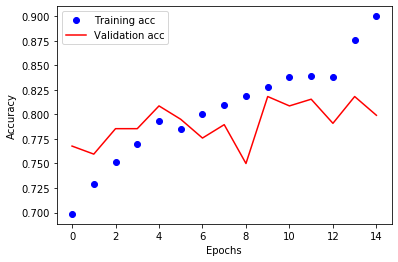

In [0]:
acc = history_finetunning.history['acc']
val_acc = history_finetunning.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# predict test data

In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 128, preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  directory="/content/test_images",
                                                  x_col="id_code",
                                                  target_size=(300, 300),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 1928 validated image filenames.


In [0]:
y_test=np.argmax(model.predict(test_generator), axis=1)

In [0]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':y_test})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(50)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0
